   - 학습 데이터 (user_id : 10000 ~ 24999, 15000명)


			- train_err_data.csv : 시스템에 발생한 에러 로그

			- train_quality_data.csv : 시스템 퀄리티 로그

			- train_problem_data.csv : 사용자 불만 및 불만이 접수된 시간


   - 테스트 데이터(user_id : 30000 ~ 44998, 14999명)


			- test_err_data.csv : 시스템에 발생한 에러 로그

			- test_quality_data.csv : 시스템 퀄리티 로그

			- sample_submission.csv : 사용자 불만 확률(0~1) (제출용)

## 사용할 Module & Data 불러오기 

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import missingno as msno
import warnings
warnings.filterwarnings(action='ignore')

In [79]:
train_err_df =pd.read_csv('../data/train_err_data.csv')
train_problem_df =pd.read_csv('../data/train_problem_data.csv')
train_quality_df =pd.read_csv('../data/train_quality_data.csv')

# err data 는 user_id 15000 명의 대한것이다

In [81]:
pd.to_datetime(train_err_df.time)

0          1970-01-01 05:36:41.101025616
1          1970-01-01 05:36:41.101030309
2          1970-01-01 05:36:41.101030309
3          1970-01-01 05:36:41.101050514
4          1970-01-01 05:36:41.101050515
                        ...             
16554658   1970-01-01 05:36:41.130163051
16554659   1970-01-01 05:36:41.130172625
16554660   1970-01-01 05:36:41.130172625
16554661   1970-01-01 05:36:41.130172631
16554662   1970-01-01 05:36:41.130210625
Name: time, Length: 16554663, dtype: datetime64[ns]

In [16]:
train_err_df.head(1)

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1


- time 을 편하게 볼수있게 datatime module 로 일단 수정해서 만들어준다

In [24]:
def make_datetime(x):
    x = str(x)
    year = int(x[:4])
    month = int(x[4:6])
    day = int(x[6:8])
    hour = int(x[8:10])
    mim = int(x[10:12])
    sec = int(x[12:])
    return dt.datetime(year,month,day,hour,mim,sec)
make_datetime(20201101025616)
train_err_df['time']= train_err_df.time.map(make_datetime)

In [28]:
train_quality_df['time']= train_quality_df.time.map(make_datetime)
train_problem_df['time']= train_problem_df.time.map(make_datetime)
display(train_problem_df)
train_quality_df

,user_id,time
0,19224,2020-11-02 20:00:00
1,23664,2020-11-16 14:00:00
2,15166,2020-11-14 13:00:00
3,12590,2020-11-08 21:00:00
4,15932,2020-11-03 21:00:00
...,...,...
5424,20167,2020-11-25 12:00:00
5425,16270,2020-11-10 12:00:00
5426,19114,2020-11-06 23:00:00
5427,21505,2020-11-04 11:00:00


,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
1,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
2,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
3,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
4,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828619,2020-11-24 03:30:00,24997,04.22.1778,0.0,0,0.0,0,0,1,0,0,0,0,17,0,0
828620,2020-11-24 03:30:00,24997,04.22.1778,0.0,0,0.0,0,0,0,0,0,0,0,17,0,0
828621,2020-11-24 03:30:00,24997,04.22.1778,0.0,0,0.0,0,0,3,0,0,0,0,17,0,0
828622,2020-11-24 03:30:00,24997,04.22.1778,0.0,0,0.0,0,0,0,0,0,0,0,17,0,0


In [19]:
dt.MINYEAR
dt.MAXYEAR


9999

### 불만접수를 err 데이터의 있는 모든 유저 가 불만접수를 했는지 확인

In [3]:
train_err_df.user_id.value_counts()
train_problem_df.user_id.value_counts()
train_quality_df.user_id.value_counts()
#quality user_id 8281
#problem user_id 5000
#err user_id     15000
#에러가 발생한 모든 유저가 불만 접수를 한것이 아님
# 그러면 특정 유저

15357    4224
23065    3828
22632    3744
11635    3504
16147    3336
         ... 
15301      12
15299      12
15298      12
21046      12
17539      12
Name: user_id, Length: 8281, dtype: int64

## EDA

In [29]:
train_quality_df.info() 
train_problem_df.info()
train_err_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828624 entries, 0 to 828623
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        828624 non-null  datetime64[ns]
 1   user_id     828624 non-null  int64         
 2   fwver       788544 non-null  object        
 3   quality_0   684192 non-null  float64       
 4   quality_1   828624 non-null  int64         
 5   quality_2   788511 non-null  float64       
 6   quality_3   828624 non-null  int64         
 7   quality_4   828624 non-null  int64         
 8   quality_5   828604 non-null  object        
 9   quality_6   828624 non-null  int64         
 10  quality_7   828624 non-null  object        
 11  quality_8   828624 non-null  object        
 12  quality_9   828624 non-null  object        
 13  quality_10  828624 non-null  object        
 14  quality_11  828624 non-null  int64         
 15  quality_12  828624 non-null  int64         
dtypes:

In [5]:
null_columns = train_quality_df.columns[train_quality_df.isnull().sum() > 0].to_list()
# 이거 왜 되지 ;; 여러개 의 행의 빈값 있는 것만 찾으려했는데 조건식 만들기가 힘드네 
for column in null_columns:
    display(train_quality_df[train_quality_df[column].isnull()])

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
38316,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38317,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38318,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38319,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38320,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828331,20201109232000,24982,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
828332,20201109232000,24982,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
828333,20201109232000,24982,NaN,NaN,-1,NaN,0,0,-1,-1,0,0,0,0,-1,0
828334,20201109232000,24982,NaN,NaN,-1,NaN,0,0,-1,-1,0,0,0,0,-1,0


,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
3852,20201104022000,10080,03.11.1149,NaN,-1,-1.0,0,0,-1,-1,0,0,3,1,-1,0
3853,20201104022000,10080,03.11.1149,NaN,-1,-1.0,0,0,-1,-1,0,0,3,1,-1,0
3854,20201104022000,10080,03.11.1149,NaN,0,2.0,0,0,1,0,0,0,3,1,0,0
3855,20201104022000,10080,03.11.1149,NaN,0,1.0,0,0,0,0,0,0,3,1,0,0
3856,20201104022000,10080,03.11.1149,NaN,0,0.0,0,0,0,0,0,0,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828511,20201121113000,24990,03.11.1167,NaN,-1,-1.0,0,0,-1,-1,0,0,0,1,-1,0
828512,20201121113000,24990,03.11.1167,NaN,-1,-1.0,0,0,-1,-1,0,0,0,1,-1,0
828513,20201121113000,24990,03.11.1167,NaN,0,0.0,0,0,0,0,0,0,0,1,0,0
828514,20201121113000,24990,03.11.1167,NaN,0,0.0,0,0,0,0,0,0,0,1,0,0


,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
38316,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38317,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38318,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38319,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38320,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828331,20201109232000,24982,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
828332,20201109232000,24982,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
828333,20201109232000,24982,NaN,NaN,-1,NaN,0,0,-1,-1,0,0,0,0,-1,0
828334,20201109232000,24982,NaN,NaN,-1,NaN,0,0,-1,-1,0,0,0,0,-1,0


,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
58907,20201128234000,11154,04.33.1261,0.0,0,0.0,0,0,NaN,0,0,0,0,"200,496",0,2
150490,20201126231000,12681,04.22.1778,0.0,0,0.0,0,0,NaN,0,11,0,0,"843,420",0,3
150491,20201126231000,12681,04.22.1778,0.0,0,0.0,0,0,NaN,0,11,0,0,"843,420",0,3
150502,20201127011000,12681,04.22.1778,0.0,0,0.0,0,0,NaN,0,0,0,0,"1,037,689",0,0
150503,20201127011000,12681,04.22.1778,0.0,0,0.0,0,0,NaN,0,0,0,0,"1,037,689",0,0
150527,20201127051000,12681,04.22.1778,0.0,0,0.0,0,0,NaN,0,0,0,0,"631,620",0,0
150538,20201127071000,12681,04.22.1778,0.0,0,0.0,0,0,NaN,0,0,0,0,"1,012,799",0,0
150539,20201127071000,12681,04.22.1778,0.0,0,0.0,0,0,NaN,0,0,0,0,"1,012,799",0,0
209696,20201122004000,13720,04.22.1750,0.0,0,0.0,0,0,NaN,0,0,0,0,"1,005,588",0,0
209697,20201122004000,13720,04.22.1750,0.0,0,0.0,0,0,NaN,0,0,0,0,"1,005,588",0,0


In [6]:
train_err_df.set_index(['user_id','errtype','model_nm']).loc[10000,'errcode']

errtype  model_nm
15       model_3     1
12       model_3     1
11       model_3     1
16       model_3     1
4        model_3     0
                    ..
15       model_3     1
16       model_3     1
4        model_3     0
         model_3     0
15       model_3     1
Name: errcode, Length: 317, dtype: object

In [7]:
np.sort(train_err_df.errtype.unique())
# 29제외 1부터 42까지 41가지 존재한다.

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42])

In [10]:
id_error = train_err_df[['user_id','errtype']].values
id_error

array([[10000,    15],
       [10000,    12],
       [10000,    11],
       ...,
       [24999,     4],
       [24999,     4],
       [24999,    15]])

In [ ]:
sns.heatmap(train_err_df.isnull(), cbar=False)

In [ ]:
msno.matrix(train_err_df)

In [13]:
train_quality_df[train_quality_df.user_id == 10693]

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
38316,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38317,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38318,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38319,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38320,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38321,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38322,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38323,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38324,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38325,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0


In [15]:
train_err_df[train_err_df.user_id == 10693]
# user_id 10693 은 model_6 만 사용했는지는 모르지만 error 이것만떳어 fwver 이 10 이라고 error 데이터에서는 보이는 그러면
# error 가 발생하고 quality 를 2시간동안 10분마다 수집하니까  근데 보면 20일에 발생한 에러는 없어 에러를 거의 2 분 3분마다 발생시키는데 
# 무슨 에러인지 모르겠네 어차피 이건 model_6 fwver 10에 대한 에러들이야

,user_id,time,model_nm,fwver,errtype,errcode
737388,10693,20201119223115,model_6,10,5,B-A8002
737389,10693,20201119223129,model_6,10,5,B-A8002
737390,10693,20201119223150,model_6,10,5,B-A8002
737391,10693,20201119223158,model_6,10,5,B-A8002
737392,10693,20201119223212,model_6,10,5,B-A8002
737393,10693,20201119223218,model_6,10,5,B-A8002
737394,10693,20201119223308,model_6,10,5,B-A8002
737395,10693,20201119223310,model_6,10,5,B-A8002
737396,10693,20201119223319,model_6,10,5,B-A8002
737397,10693,20201119223321,model_6,10,5,B-A8002


In [49]:
%%time
# quailty 에서 fwver 가 nan인게 뭐뭐가 있는지 fwver 가 빈것들은 다 퀄리티 0 과 2가 비어있는지 봐보자
train_quality_df.loc[train_quality_df.fwver.isnull(),['quality_0','quality_2']].notnull().sum()
# 다 비어 있다 그러면 모델이 같은지 한번 봐보자
null_qual_0_1 = train_quality_df.loc[train_quality_df.fwver.isnull(),'user_id'].unique() # 개수는 59개

def isin_null_0_1(x):
    if x in null_qual_0_1:
        return True
    else:
        return False
null_0_1 = train_err_df[train_err_df.user_id.map(isin_null_0_1)]
'''
model_6    1639
model_0    1630
model_2     783
model_3      43
'''
null_0_1[null_0_1.model_nm == "model_6"].fwver.value_counts()
#array(['model_6', 'model_3', 'model_0', 'model_2'], dtype=object)

CPU times: user 23.9 s, sys: 132 ms, total: 24.1 s
Wall time: 24.1 s


10       1455
8.5.3     184
Name: fwver, dtype: int64

In [47]:
# model 종류가 몇가지나 있나 한번 봐보자 
train_err_df.model_nm.value_counts()
# 빈것들의 에러코드는 같은지 or model 이 같은지 
# 퀄리티 별 숫자가 같은지 로봐보자 

model_1    5384491
model_0    4176279
model_2    3473254
model_3    1907438
model_4    1507802
model_8      36064
model_7      35356
model_5      32233
model_6       1746
Name: model_nm, dtype: int64

In [60]:
train_quality_df[train_quality_df.columns[3:]].iloc[:,0].value_counts(normalize=True)

 0.0       0.793330
-1.0       0.191215
 1.0       0.003065
 2.0       0.001830
 3.0       0.000757
             ...   
 1113.0    0.000001
 1177.0    0.000001
 1186.0    0.000001
 946.0     0.000001
 2351.0    0.000001
Name: quality_0, Length: 753, dtype: float64

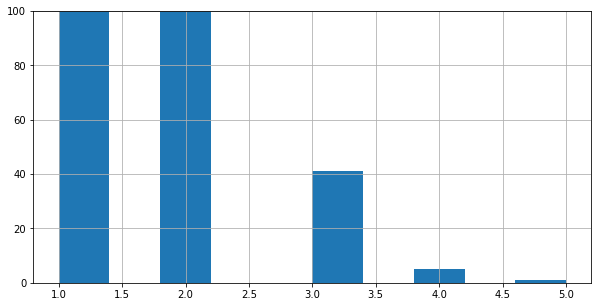

In [78]:
# null_0_1.errtype.value_counts()
# model_nm 과 error 타입을 연결시키는건 좀 힘들고
# user_id 별로 무슨 error type 이나 error code에 대한 불만을 많이 썻는지
# 그 에러들의 퀄리티 점수 분포는 어떻게 되는지 로 보면 될거같은데
# 결측 치 채우기는 다음에 위에꺼 부터
plt.figure(figsize =(10,5))
train_problem_df.user_id.value_counts().hist()
plt.ylim(0,100)
plt.show()
# 분포로 보려면

## Data Preprocessing

## Modeling & Training

## Test & measure performance